# Challenge: fit parameters to differential equation system

We have a (first order) biocatalytic reaction:

a <--> b

Which means that we have 2 different concentrations to be measured: **the substrate** and the **product**. 

## Target:

Fit parameters to the known model

<img src="./assets/worklfow_example_1.png">


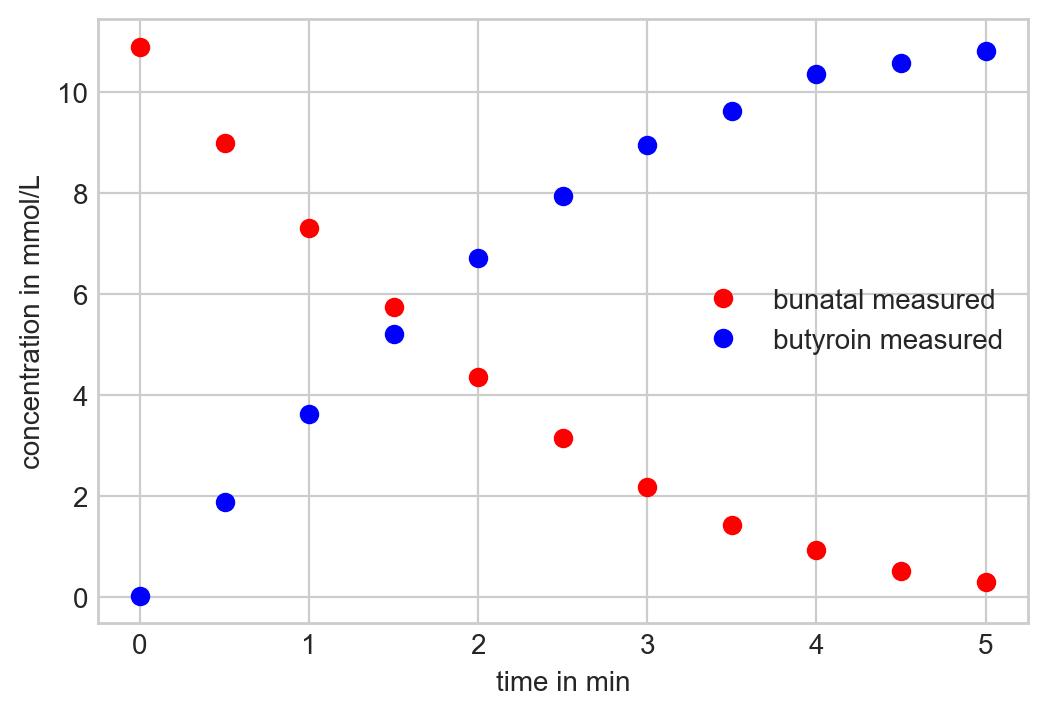

In [45]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Full Conversion Approach.xlsx", sheet_name = "10mL_viualisation")
plt.rcParams["figure.dpi"] = 200

time = df["time in min"]
substrate = df["3-OH-BA"]
product = df["(S)-3-OH-PAC"]

time_before_feed = time.iloc[:11]
substrate_before_feed = substrate.iloc[:11]
product_before_feed = product.iloc[:11]
fix, ax = plt.subplots()
ax.plot(time_before_feed, substrate_before_feed, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="butyroin measured", color="blue", linestyle="", marker="o")
ax.set_xlabel("time in min")
ax.set_ylabel("concentration in mmol/L")
ax.legend()


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

data_list = [substrate_before_feed,product_before_feed]

print(time_before_feed)


data = np.array(data_list)

y0_array = np.array([11, 0])
y0 = [20]

def dadt(y, t, p):
    dadt = -p[0]*y[0]
    dbdt = p[0]*y[1] - p[1]*y[1]
    #dadt = -p[0]*y[0] + p[1]*y[0]
    return [dadt, dbdt]



# test data

substrates = np.reshape(np.array(substrate_before_feed), (11, 1))
products = np.reshape(np.array(product_before_feed), (11, 1))
measured_data = np.column_stack((substrates,products))
times = np.array(time_before_feed)

# time array needs the shape (,11) and the data (11,1) 

ode_model = DifferentialEquation(func=dadt, times=times, n_states=2, n_theta=2)

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    Ka = pm.Uniform("Ka", 0, 1)
    init = pm.Normal("init",11, 1)
    Kb = pm.Uniform("Kb", 0, 0.000000001)
    sigma = pm.Normal("sigma", 0.1)

    ode_solution = ode_model(y0=[11,0], theta=[Ka, Kb])

    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=measured_data)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

data = az.from_pymc3(trace=trace)

ode_solution_1 = ode_model(y0=[11,0], theta=[0.02, 0.00001])
print(ode_solution_1[0])


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


0     0.0
1     0.5
2     1.0
3     1.5
4     2.0
5     2.5
6     3.0
7     3.5
8     4.0
9     4.5
10    5.0
Name: time in min, dtype: float64


c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, Kb, init, Ka]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 555 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\SMalz\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Subtensor{int64}.0


[4.50924179 3.99331235 3.69179616 ... 4.25399438 4.04099236 4.30555388]
<class 'pymc3.backends.base.MultiTrace'>


array([<AxesSubplot:title={'center':'init'}>,
       <AxesSubplot:title={'center':'sigma'}>,
       <AxesSubplot:title={'center':'Ka'}>,
       <AxesSubplot:title={'center':'Kb'}>], dtype=object)

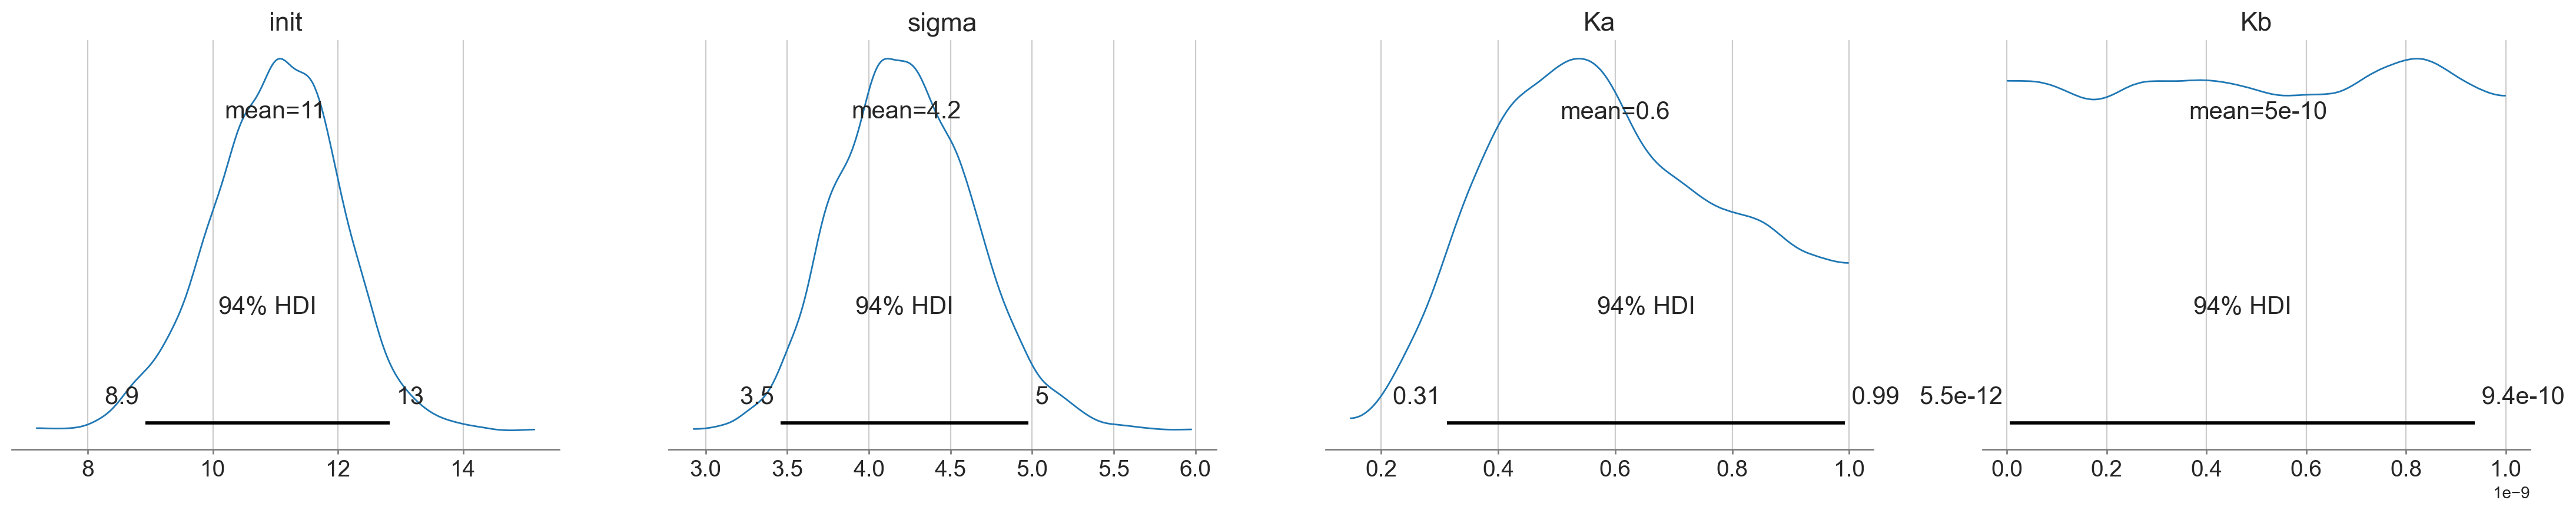

In [14]:
#data = az.from_pymc3(trace=trace)
print(trace["sigma"])
print(type(trace))
az.plot_posterior(data)

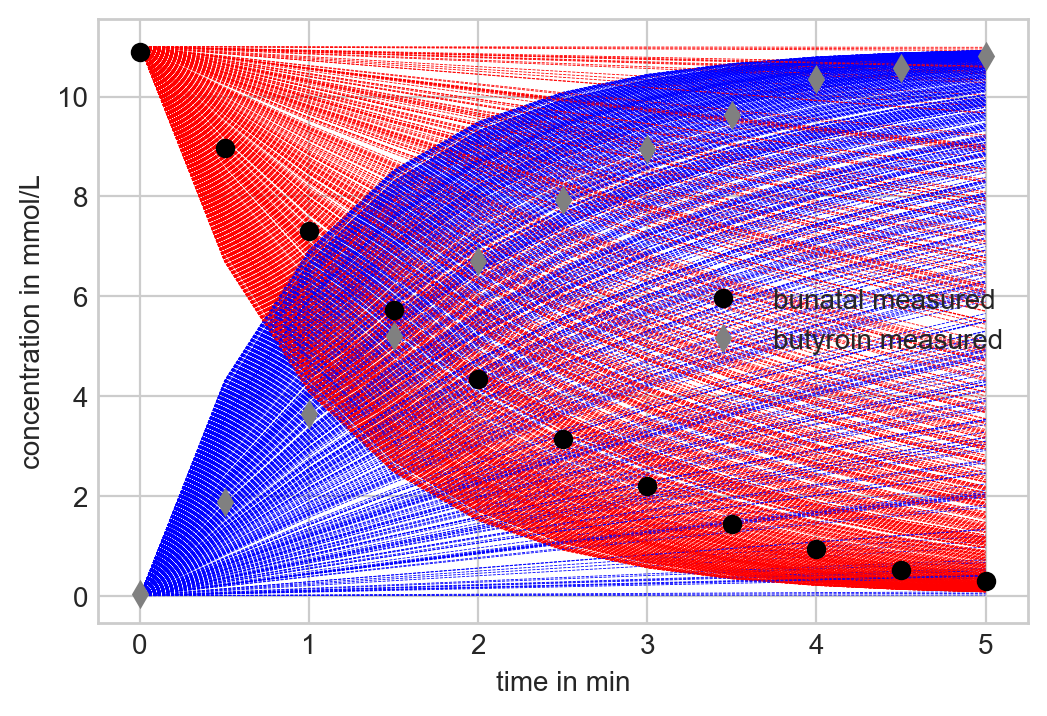

In [48]:
from scipy.integrate import odeint
fig, pri = plt.subplots()
plt.style.use(['seaborn-whitegrid'])
plt.rcParams['lines.linewidth'] = 1

def dxdt(kA, kP, A,P, t):
    dadt = -kA*A + kP*P
    return dadt

def dbdt(kA, kP, A, P, t):
        dbdt = kA*A - kP*P 
        return dbdt

def dglsys(init_cond_array, t, kA, kP):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = dxdt(kA, kP, A, P, t)
    dBdt = dbdt(kA, kP, A, P,t)
    dZdt = np.array([dAdt, dBdt])
    return dZdt

for i,j in zip(prior["Ka"],prior["Kb"]):
    sol = odeint(dglsys, [11,0], time_before_feed, args=(i, j))
    #sol = odeint(dadt, [11,0], time_before_feed, args=(i, j))

    pri.plot(time_before_feed, sol[:,1], linestyle="--", linewidth=0.3, color="blue")
    pri.plot(time_before_feed, sol[:,0], linestyle="--", linewidth=0.3, color="red")
    
pri.plot(time_before_feed, substrate_before_feed, label="bunatal measured", color="black", linestyle="", marker="o")
pri.plot(time_before_feed, product_before_feed, label="butyroin measured", color="grey", linestyle="", marker="d")
pri.set_xlabel("time in min")
pri.set_ylabel("concentration in mmol/L")
pri.legend()
